## Install the required pkg

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=3291e163c3cd3ecf181e50d29a73306097c5429ade499439465a2dbd7c8ab86f
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


## Import the required libs

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wget
from keras.utils import np_utils
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading data

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'

# Download data
wget.download(url)

# Unzip data into the root data
!unzip -q traffic-signs-data.zip -d $'./'

## Traffic Sign Model

In [4]:
class TrafficSignModel(object):
    def __init__(
        self,
        input: tuple = (32, 32, 3),
        kernel_size: list = [3, 2],
        layer: list = [32, 64, 128, 256, 512],
        output_layer: int = 43,
    ) -> None:
        """Initialize the traffic sign model

        Args:
            input: Input shape of model. Defaults to (32, 32, 3).
            kernel_size: List size of kernel. Defaults to [3, 2].
            layer: Num of layer. Defaults to [32, 64, 128, 256, 512].
            output_layer: Output layer of model. Defaults to 43.
        """
        self._input = input
        self._kernel_size = kernel_size
        self._layer = layer
        self._output_layer = output_layer

        self._model = None

        # Visualize parameter
        self._rows = 3
        self._columns = 4
        self._fig_size = (15, 15)

        # Augumentation data
        self._datagen = ImageDataGenerator(
            rotation_range=0.18,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
        )

        self._X_train, self._y_train = self._pre_processing_data("train.p")
        self._X_val, self._y_val = self._pre_processing_data("valid.p")
        self._X_test, self._y_test = self._pre_processing_data("test.p")

        # Mapping label
        self._label = {
            0: "Speed limit (20km/h)",
            1: "Speed limit (30km/h)",
            2: "Speed limit (50km/h)",
            3: "Speed limit (60km/h)",
            4: "Speed limit (70km/h)",
            5: "Speed limit (80km/h)",
            6: "End of speed limit (80km/h)",
            7: "Speed limit (100km/h)",
            8: "Speed limit (120km/h)",
            9: "No passing",
            10: "No passing for vehicles over 3.5 metric tons",
            11: "Right-of-way at the next intersection",
            12: "Priority road",
            13: "Yield",
            14: "Stop",
            15: "No vehicles",
            16: "Vehicles over 3.5 metric tons prohibited",
            17: "No entry",
            18: "General caution",
            19: "Dangerous curve to the left",
            20: "Dangerous curve to the right",
            21: "Double curve",
            22: "Bumpy road",
            23: "Slippery road",
            24: "Road narrows on the right",
            25: "Road work",
            26: "Traffic signals",
            27: "Pedestrians",
            28: "Children crossing",
            29: "Bicycles crossing",
            30: "Beware of ice/snow",
            31: "Wild animals crossing",
            32: "End of all speed and passing limits",
            33: "Turn right ahead",
            34: "Turn left ahead",
            35: "Ahead only",
            36: "Go straight or right",
            37: "Go straight or left",
            38: "Keep right",
            39: "Keep left",
            40: "Roundabout mandatory",
            41: "End of no passing",
            42: "End of no passing by vehicles over 3.5 metric tons",
        }

    def plot(self) -> None:
        """Show some the traffic sign."""
        fig = plt.figure(figsize=self._fig_size)

        for i in range(1, self._columns * self._rows + 1):
            ax = fig.add_subplot(self._rows, self._columns, i)
            plt.title(self._label[np.argmax(self._y_train[i])])
            plt.imshow(self._X_train[i], interpolation="nearest")
        plt.show()

    def _pre_processing_data(self, data_file: str) -> None:
        """Pre-processing data.

        Args:
            data_file: Path of data file

        Returns: Data after processing
        """
        with open(data_file, mode="rb") as f:
            data = pickle.load(f)
        X_data = data["features"]
        y_data = data["labels"]

        # Normalize data to range 0-1
        X = X_data.astype("float32") / 255.0

        # Convert to one hot encode
        y = np_utils.to_categorical(y_data)

        # Shuffle data
        X, y = shuffle(X, y)

        return X, y

    def _define_model(self) -> None:
        """Define Sequential model"""
        model = Sequential()
        model.add(
            Conv2D(
                self._layer[0],
                (self._kernel_size[0], self._kernel_size[0]),
                activation="relu",
                padding="same",
                input_shape=self._input,
            )
        )
        model.add(BatchNormalization())
        model.add(
            Conv2D(
                self._layer[0],
                (self._kernel_size[0], self._kernel_size[0]),
                padding="same",
                activation="relu",
            )
        )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(self._kernel_size[1], self._kernel_size[1]))
        model.add(
            Conv2D(
                self._layer[1],
                (self._kernel_size[0], self._kernel_size[0]),
                padding="same",
                activation="relu",
            )
        )
        model.add(BatchNormalization())
        model.add(
            Conv2D(
                self._layer[1],
                (self._kernel_size[0], self._kernel_size[0]),
                padding="same",
                activation="relu",
            )
        )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(self._kernel_size[1], self._kernel_size[1]))
        model.add(Flatten())
        model.add(Dense(self._layer[4], activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(self._output_layer, activation="softmax"))

        self._model = model

        self._model.summary()

    def _compile_model(self) -> None:
        """Compile model."""
        self._define_model()
        self._model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

    def train(self) -> None:
        """Fit the model"""
        self._compile_model()
        # Checkpoint
        _file_path = "top.weights.hdf5"
        _check_point = ModelCheckpoint(
            _file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode=max
        )
        _callbacks_list = [_check_point]

        self._H = self._model.fit(
            self._datagen.flow(self._X_train, self._y_train, batch_size=256),
            validation_data=(self._X_val, self._y_val),
            epochs=20,
            verbose=1,
        )

        self._model.save_weights("traffic_sign_model.h5")

    def visualize(self) -> None:
        """Visualize the accuracy and loss."""
        print(self._H.history.keys())
        fig = plt.figure()

        # Plot accuracy and val_accuracy
        plt.plot(self._H.history["accuracy"])
        plt.plot(self._H.history["val_accuracy"])
        plt.xlabel("epochs")
        plt.ylabel("acc and val_acc")
        plt.title("accuracy")
        plt.legend(["train", "val"], loc="upper left")
        plt.show()

        plt.figure()
        # Plot loss and val_loss
        plt.plot(self._H.history["loss"])
        plt.plot(self._H.history["val_loss"])
        plt.xlabel("epochs")
        plt.ylabel("loss and val_loss")
        plt.title("loss")
        plt.legend(["train", "val"])
        plt.show()

    def evalue_model(self) -> None:
        """Evaluate the model."""
        loss, acc = self._model.evaluate(self._X_test, self._y_test, verbose=2)
        print("Accuracy: %.3f" % acc)
        print("Loss: %.3f" % loss)

    def predict_model(self) -> None:
        """Prediction."""
        y_predict = self._model.predict(self._X_test)

        # Show some predict
        fig = plt.figure(figsize=self._fig_size)

        for i in range(self._rows * self._columns):
            ax = fig.add_subplot(self._rows, self._columns, i + 1)
            plt.title(
                "Predict: "
                + self._label[np.argmax(y_predict[i])]
                + "\n"
                + "Actual: "
                + self._label[np.argmax(self._y_test[i])]
            )
            plt.imshow(self._X_test[i], interpolation="nearest")
        plt.show()

### Define model

In [5]:
model = TrafficSignModel()

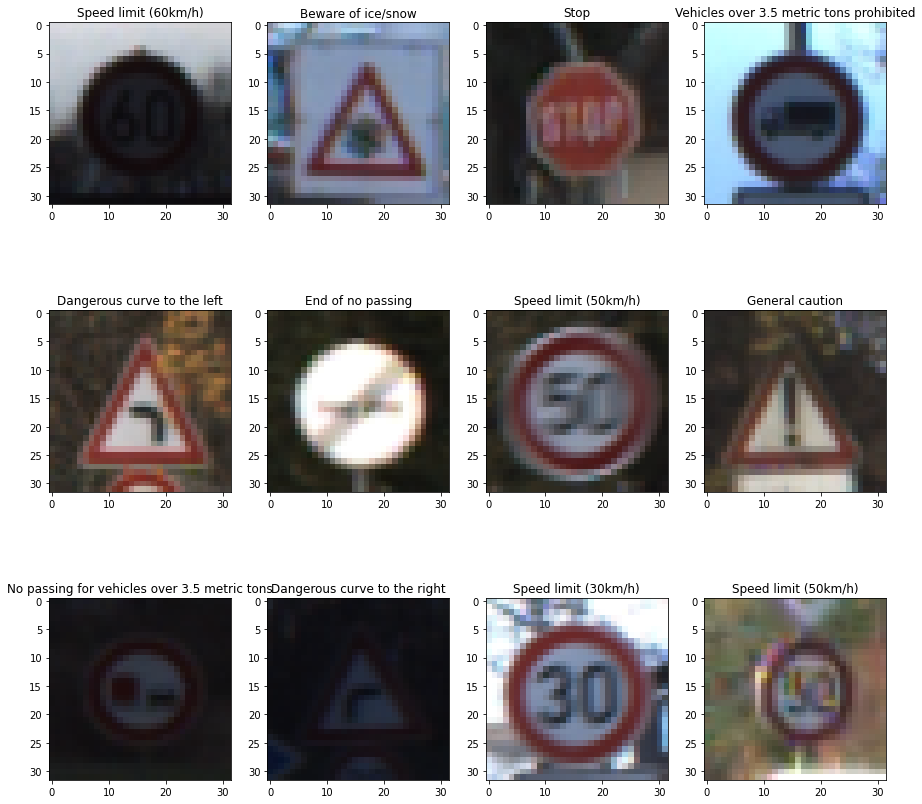

In [6]:
# Show some traffic sign
model.plot()

### Compile & train the model

In [7]:
model.train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

Epoch 1/20
136/136 [==============================] - 283s 2s/step - loss: 1.5185 - accuracy: 0.5708 - val_loss: 4.7443 - val_accuracy: 0.0907
Epoch 2/20
136/136 [==============================] - 287s 2s/step - loss: 0.4109 - accuracy: 0.8756 - val_loss: 6.9067 - val_accuracy: 0.0438
Epoch 3/20
136/136 [==============================] - 284s 2s/step - loss: 0.1683 - accuracy: 0.9526 - val_loss: 4.6283 - val_accuracy: 0.2812
Epoch 4/20
136/136 [==============================] - 288s 2s/step - loss: 0.0834 - accuracy: 0.9773 - val_loss: 1.3297 - val_accuracy: 0.6705
Epoch 5/20
136/136 [==============================] - 287s 2s/step - loss: 0.0498 - accuracy: 0.9870 - val_loss: 0.4739 - val_accuracy: 0.8701
Epoch 6/20
136/136 [==============================] - 293s 2s/step - loss: 0.0383 - accuracy: 0.9903 - val_loss: 0.3922 - val_accuracy: 0.9014
Epoch 7/20
136/136 [==============================] - 288s 2s/step - loss: 0.0293 - accuracy: 0.9926 - val_loss: 0.3971 - val_accuracy: 0.9075

### Visualize accuracy and loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


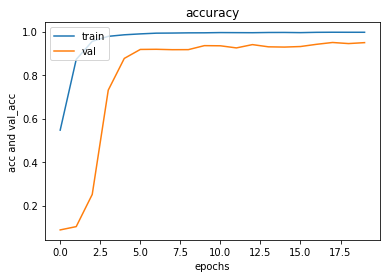

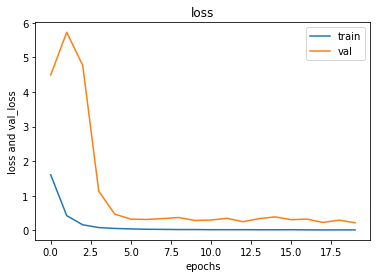

In [ ]:
model.visualize()

### Evaluate the model

In [ ]:
model.evalue_model()

395/395 - 1s - loss: 0.2271 - accuracy: 0.9428 - 1s/epoch - 3ms/step
Accuracy: 0.943
Loss: 0.227


### Prediction

395/395 [==============================] - 1s 3ms/step
Predict model: [[3.4592778e-04 6.2529725e-05 6.4985940e-08 ... 1.0992608e-04
  1.5590989e-06 2.9050750e-07]
 [6.2775979e-07 5.1209472e-06 1.1950735e-10 ... 5.5268686e-07
  5.6367736e-07 1.1572666e-07]
 [4.2432653e-08 8.5181529e-07 2.3130176e-06 ... 5.5102958e-09
  8.3644181e-08 5.8295154e-05]
 ...
 [3.5914535e-11 4.6558046e-11 7.8447513e-08 ... 2.1050268e-10
  7.3789880e-07 1.3166950e-09]
 [2.1880977e-09 1.0877121e-06 2.2113952e-06 ... 1.2012318e-04
  1.0931708e-06 2.8911418e-05]
 [1.3054398e-08 6.3595840e-09 1.2277243e-10 ... 6.6327535e-09
  5.5539182e-08 7.4350294e-07]]


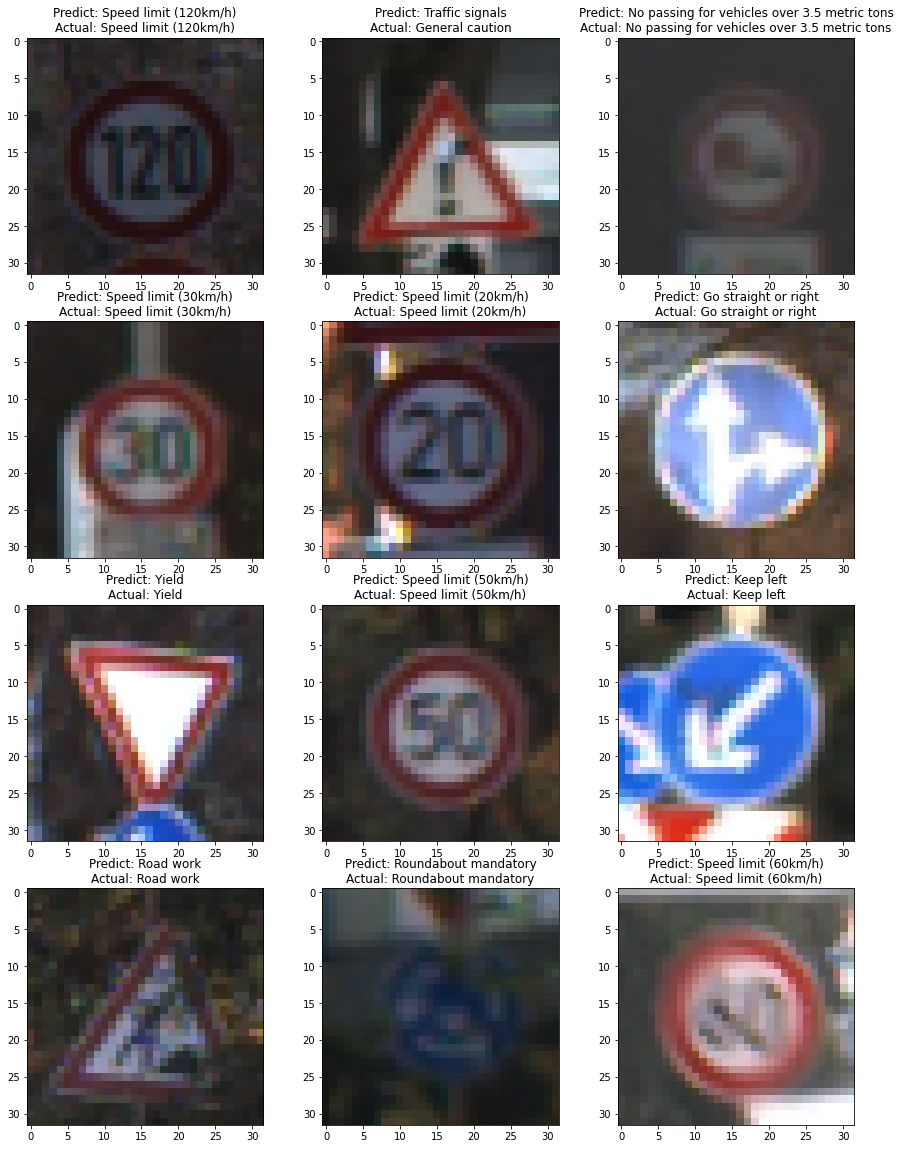

In [ ]:
model.predict_model()